# 2021/10/08
The jupypter notebook is used to test the pipleine for the random forest + SMOTE pipeline intergration from sklearn


In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [7]:
import pandas as pd
import numpy as np
import sys, os

# Pre-precess data to get the merged one

## Explore feature

In [8]:
input_path='/pod/2/li-lab/Ziwei/Nanopore/daily/test/'
#df=pd.read_csv(os.path.join(input_path, 'total.Megalodon.per_read.prob.bed.gz'),compression='gzip', sep='\t')
df=pd.read_csv(os.path.join(input_path, 'total.test.bed'), sep='\t')
print("Data is loading!")

#Splitting the data into independent and dependent variables
df_feature = df.loc[:,['5hmC_prob','5mC_prob','5C_prob']].values
df_class = df.loc[:,['label']].values
df_class = np.squeeze(df_class) #Convert the label into 1d-array

df

Data is loading!


,chr,start,read_id,strand,5hmC_prob,5mC_prob,5C_prob,label
0,KJ477685.1,204,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.435397,0.085058,0.479545,2
1,KJ477685.1,261,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.342189,0.500821,0.156990,2
2,KJ477685.1,261,fe8be0cc-f4c4-49f1-80db-c840a6c7dfe9,-,0.577034,0.057676,0.365290,2
3,KJ477685.1,266,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.065316,0.861569,0.073115,2
4,KJ477685.1,266,fe8be0cc-f4c4-49f1-80db-c840a6c7dfe9,-,0.794235,0.028885,0.176880,2
...,...,...,...,...,...,...,...,...
2492,J02459.1,60,bb826a6c-c88b-45ac-9984-8b9d6bfb2f11,-,0.054875,0.013023,0.932103,0
2493,J02459.1,60,bb91267a-6661-4248-a084-554f231398c1,-,0.030720,0.004392,0.964888,0
2494,J02459.1,60,bb9cee29-89d0-4a68-a4b4-8fe5c000289f,-,0.032703,0.006934,0.960363,0
2495,J02459.1,60,bbee6b4a-acac-4db9-bbb8-2f379918b146,-,0.035734,0.003182,0.961085,0


In [9]:
df['label'].value_counts()

1    999
0    999
2    499
Name: label, dtype: int64

# Correct Strategy
We should split into training and validation folds. Then, on each fold, we should

1. Oversample the minority class

1. Train the classifier on the training fold

1. Validate the classifier on the remaining fold

https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [12]:
#Load the feature
#df=pd.read_csv(os.path.join(input_path, 'total.Megalodon.per_read.prob.bed.gz'),compression='gzip', sep='\t')
df=pd.read_csv(os.path.join(input_path, 'total.test.bed'), sep='\t')

#Splitting the data into independent and dependent variables
df_feature = df.loc[:,['5hmC_prob','5mC_prob','5C_prob']].values
df_class = df.loc[:,['label']].values
df_class = np.squeeze(df_class) #Convert the label into 1d-array

X = df_feature
y = df_class
X, y

(array([[0.43539682, 0.0850578 , 0.47954538],
        [0.34218898, 0.50082132, 0.1569897 ],
        [0.5770338 , 0.05767577, 0.36529042],
        ...,
        [0.03270286, 0.00693383, 0.96036331],
        [0.03573376, 0.0031817 , 0.96108454],
        [0.04024863, 0.00401376, 0.95573762]]),
 array([2, 2, 2, ..., 0, 0, 0]))

In [13]:
#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

## Test with single parameter

In [37]:
# Make the pipeline
# https://medium.com/@cezinejang/introduction-to-machine-learning-pipelines-adb041120856

pipe_smote_rf = imbpipeline(steps = [('smote', SMOTE(random_state=42)),
                                     ('rfr', RandomForestClassifier(random_state=42))])

In [38]:
# Define parameter for grid search
#Define rf classifier

#5x1x3x2x2x2=168
n_estimators =  [x for x in range(60, 150, 20)] # number of trees in the random forest
max_features = ['auto'] # number of features in consideration at every split
max_depth = [2,5,10] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 5] # minimum sample number to split a node
min_samples_leaf = [1, 2] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points"


params = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'bootstrap': bootstrap}

#assign the parameters to the named step in the pipeline. In your case classifier
params = {'rfr__' + key: params[key] for key in params}
params

{'rfr__n_estimators': [60, 80, 100, 120, 140],
 'rfr__max_features': ['auto'],
 'rfr__max_depth': [2, 5, 10],
 'rfr__min_samples_split': [2, 5],
 'rfr__min_samples_leaf': [1, 2],
 'rfr__bootstrap': [True, False]}

In [39]:
# Define cross-validation fold
stratified_kfold = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

In [40]:
##GridSearchCV
rf_random_search = GridSearchCV(estimator = pipe_smote_rf, 
                                param_grid = params, 
                                scoring='f1_macro', 
                                cv=stratified_kfold, 
                                verbose=1, 
#                               return_train_score=True, 
                                n_jobs=-1)

rf_result = rf_random_search.fit(X_train, y_train)

y_true, y_pred = y_test, rf_random_search.predict(X_test)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [41]:
cv_score = rf_result.best_score_
test_score = rf_result.score(X_test, y_test)

print ('Best Parameters: ', rf_result.best_params_, ' \n')
print('Best f1_score in cv:', cv_score, '\n')
print('Test score:', test_score)

Best Parameters:  {'rfr__bootstrap': True, 'rfr__max_depth': 5, 'rfr__max_features': 'auto', 'rfr__min_samples_leaf': 2, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 80}  

Best f1_score in cv: 0.9062564948951842 

Test score: 0.8584230368033103


# Ploting the confusion matrix with best parameter

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'True label'
    cm.columns.name = 'Predicted label'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="Greens")
    plt.savefig(filename)

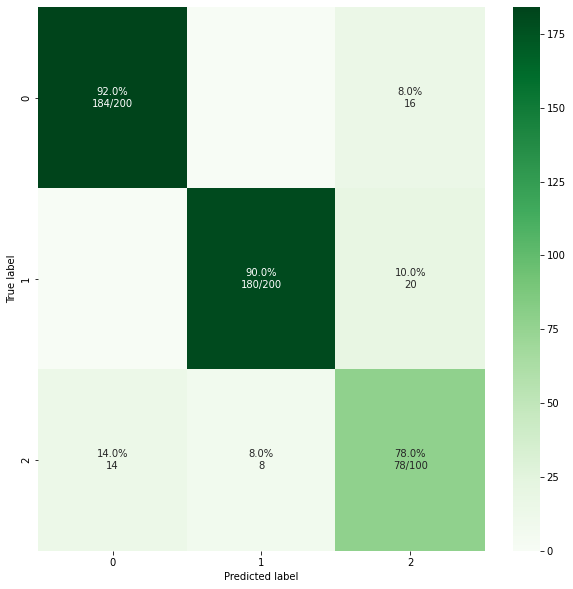

In [155]:
output_path='/pod/2/li-lab/Ziwei/Nanopore/daily/2021-10-08'
cm_analysis(y_true, y_pred, os.path.join(output_path, 'test.png'),
            labels = None, ymap=None, figsize=(10,10))

## Classification report for the best parameter

In [156]:
label = ['5C', '5mC', '5hmC']
report = classification_report(y_true, y_pred, target_names = label, digits = 4, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

NameError: name 'classification_report' is not defined